In [3]:
import pandas as pd
import glob
import re
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
def harvest_mod_outputs(path, file_pattern, output_filename=None):
    """
    Processes files in a directory matching a pattern, extracts parameters from filenames,
    and creates subplots comparing linear vs neural correlations by QTL parameter.

    Args:
        path: String path to the directory containing files
        file_pattern: String pattern for glob to match files (e.g., 'qhaplo_*qtl_*marker_*n_rep*_*.csv')
        output_filename: Optional filename for saving the plot (default: 'correlation_comparison.png')

    Returns:
        DataFrame: Combined dataframe of all processed files
        Figure: Matplotlib figure object for further customization if needed
    """
    # Get all files that match the pattern
    csv_files = glob.glob(os.path.join(path, file_pattern))

    if not csv_files:
        print(f"No files found matching pattern '{file_pattern}' in '{path}'")
        return None, None

    # Create an empty list to store individual dataframes
    dfs = []

    # Process each file
    for file in csv_files:
        # Extract the filename from the path
        filename = os.path.basename(file)

        # Extract parameters using regex
        qtl_match = re.search(r'(\d+)qtl', filename)
        n_match = re.search(r'(\d+)n', filename)
        rep_match = re.search(r'rep(\d+)', filename)

        if qtl_match and n_match and rep_match:
            qtl_value = int(qtl_match.group(1))
            n_value = int(n_match.group(1))
            rep_value = int(rep_match.group(1))

                # Read the CSV file
            df = pd.read_csv(file)

            # Add columns for the parameters
            df['qtl_param'] = qtl_value
            df['n_param'] = n_value
            df['rep'] = rep_value

            # Add the dataframe to our list
            dfs.append(df)
        else:
            print(f"Couldn't extract parameters from {filename}")

    # Combine all dataframes into one
    if dfs:
        outdf = pd.concat(dfs, ignore_index=True)

        # Display the first few rows of the combined dataframe
        print(outdf.head())

    else:
        print("No matching files found or parameters couldn't be extracted")
    return outdf

In [18]:
rrBLUP = harvest_mod_outputs('./linear_model', 'qhaplo_*qtl_*n_rep*_scklrr_corr_summary.txt')
linear_df = harvest_mod_outputs('./gplinear', 'qhaplo_*qtl_*n_rep*_phenotype_correlations_untuned.csv')


   trait  pearson_corr_pheno_mean  pearson_corr_pheno_std  \
0      1                 0.999338                0.000112   
1      2                 0.879912                0.008983   
2      3                 0.687073                0.049378   
3      4                 0.563656                0.035968   
4      5                 0.247933                0.059028   

   pearson_corr_beta_mean  pearson_corr_beta_std  best_lambda_mean  \
0                0.999936               0.000005          0.020203   
1                0.983624               0.001552          5.722368   
2                0.951097               0.004199         21.183731   
3                0.928319               0.004382         31.440511   
4                0.790094               0.015961        167.939284   

   best_lambda_std  qtl_param  n_param  rep  
0         0.002160         90     1000    1  
1         0.000000         90     1000    1  
2         2.475567         90     1000    1  
3         3.687218         9

In [24]:
rrBLUP.rename(columns={'pearson_corr_pheno_mean':'pearson_correlation'}, inplace=True)
rrBLUP.rename(columns={'trait':'trait_number'}, inplace=True)


In [25]:
rrBLUP

,trait_number,pearson_correlation,pearson_corr_pheno_std,pearson_corr_beta_mean,pearson_corr_beta_std,best_lambda_mean,best_lambda_std,qtl_param,n_param,rep
0,1,0.999338,0.000112,0.999936,5.182144e-06,0.020203,2.159611e-03,90,1000,1
1,2,0.879912,0.008983,0.983624,1.552136e-03,5.722368,0.000000e+00,90,1000,1
2,3,0.687073,0.049378,0.951097,4.199113e-03,21.183731,2.475567e+00,90,1000,1
3,4,0.563656,0.035968,0.928319,4.382362e-03,31.440511,3.687218e+00,90,1000,1
4,5,0.247933,0.059028,0.790094,1.596102e-02,167.939284,2.049415e+01,90,1000,1
...,...,...,...,...,...,...,...,...,...,...
495,1,0.999490,0.000015,0.999993,4.209197e-07,0.034305,0.000000e+00,142,10000,5
496,2,0.937742,0.002744,0.998755,1.143270e-04,4.534879,9.362223e-16,142,10000,5
497,3,0.702558,0.011421,0.991226,5.440568e-04,36.783798,0.000000e+00,142,10000,5
498,4,0.656235,0.012190,0.988421,4.771840e-04,46.415888,0.000000e+00,142,10000,5


In [26]:
def get_parameter_combinations(df1, df2):
    # Get all unique combinations from both dataframes
    params1 = df1[['qtl_param', 'n_param', 'trait_number', 'rep']].drop_duplicates()
    params2 = df2[['qtl_param', 'n_param', 'trait_number', 'rep']].drop_duplicates()

    # Find common combinations using merge
    common_params = pd.merge(params1, params2, on=['qtl_param', 'n_param', 'trait_number', 'rep'])

    return common_params


In [27]:
common_params = get_parameter_combinations(linear_df, rrBLUP)


In [28]:
def generate_comparison_df(df1, df2, common_params):
    """
    Generates paired comparison dataframe from two input dataframes that contain prediciton results from different models

    Args: The two dataframes to compare, and common param combinations
    Returns: Single dataframe with paired up outputs
    """
    comparison_data = []

    for _, row in common_params.iterrows():
        qtl = row['qtl_param']
        n = row['n_param']
        trait = row['trait_number']
        rep = row['rep']

        linear_row = df1[(df1['qtl_param'] == qtl) &
                            (df1['n_param'] == n) &
                            (df1['trait_number'] == trait) &
                            (df1['rep'] == rep)]

        neural_row = df2[(df2['qtl_param'] == qtl) &
                            (df2['n_param'] == n) &
                            (df2['trait_number'] == trait)&
                            (df2['rep'] == rep)]

        if not linear_row.empty and not neural_row.empty:
            comparison_data.append({
                'qtl_param': qtl,
                'n_param': n,
                'trait_number': trait,
                'rep': rep,
                'linear_correlation': linear_row['pearson_correlation'].values[0],
                'neural_correlation': neural_row['pearson_correlation'].values[0],
                'difference': (neural_row['pearson_correlation'].values[0] - linear_row['pearson_correlation'].values[0])/linear_row['pearson_correlation'].values[0]
            })

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df


In [29]:
comparison_df = generate_comparison_df(linear_df, rrBLUP, common_params)


In [30]:
def plot_difference_scatter(comparison_df):
    """
    Creates a scatter plot with fitted splines showing the difference between neural and linear models,
    with QTL number on x-axis (log scaled) and difference on y-axis.
    Points and splines are colored by sample size.
    """
    import numpy as np
    from scipy.interpolate import UnivariateSpline

    # Get unique traits and sample sizes
    unique_traits = sorted(comparison_df['trait_number'].unique())
    unique_n = sorted(comparison_df['n_param'].unique())

    num_traits = len(unique_traits)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_traits, figsize=(5*num_traits, 6), sharey=True)

    # If there's only one trait, axes won't be an array
    if num_traits == 1:
        axes = [axes]

    # Create a colormap for sample sizes
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(unique_n)))

    for i, trait in enumerate(unique_traits):
        # Filter data for this trait
        trait_data = comparison_df[comparison_df['trait_number'] == trait]

        # For each sample size, plot points and fit a smoother curve
        for j, n in enumerate(unique_n):
            # Filter data for this sample size
            n_data = trait_data[trait_data['n_param'] == n]

            # Sort by QTL parameter for proper fitting
            n_data = n_data.sort_values('qtl_param')

            # Extract x and y data
            x_data = n_data['qtl_param'].values
            y_data = n_data['difference'].values

            # Plot the scatter points
            axes[i].scatter(x_data, y_data, color=colors[j], s=50, alpha=0.7)

            # Only proceed if we have enough data points
            if len(x_data) >= 4:
                # Use log of x for fitting to handle the log scale properly
                log_x = np.log10(x_data)

                # Fit a smoother spline with regularization
                # Adjust smoothing factor s to control how closely the curve follows points
                s = len(x_data) * 0.5  # Adjust this value as needed
                try:
                    spline = UnivariateSpline(log_x, y_data, s=s)

                    # Create smooth points for plotting
                    log_x_smooth = np.linspace(min(log_x), max(log_x), 100)
                    y_smooth = spline(log_x_smooth)

                    # Convert back to original scale for plotting
                    x_smooth = 10**log_x_smooth

                    # Plot the smoothed line
                    axes[i].plot(x_smooth, y_smooth, '-', color=colors[j],
                                linewidth=2, label=f'n = {n}' if i == 0 else "")
                except Exception:
                    # If spline fitting fails, use a simpler approach
                    # Just connect the points with straight lines
                    axes[i].plot(x_data, y_data, '-', color=colors[j], alpha=0.5,
                                linewidth=1.5, label=f'n = {n}' if i == 0 else "")

        # Set x-axis to log scale
        axes[i].set_xscale('log')

        # Add a horizontal line at y=0
        axes[i].axhline(y=0, color='gray', linestyle='--', alpha=0.7)

        # Set title and labels
        axes[i].set_title(f'Trait {trait}')
        axes[i].set_xlabel('QTL Number (log scale)')

        if i == 0:
            axes[i].set_ylabel('Difference (Neural - Linear)')

        # Set y-axis limits consistently
        y_max = abs(comparison_df['difference']).max() * 1.1  # Add 10% padding
        axes[i].set_ylim(-1, 3)

    # Add legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.005),
              ncol=len(unique_n), title="Sample Size")

    plt.suptitle('Neural Network vs Linear Model Performance Difference by Trait', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust layout for suptitle and legend


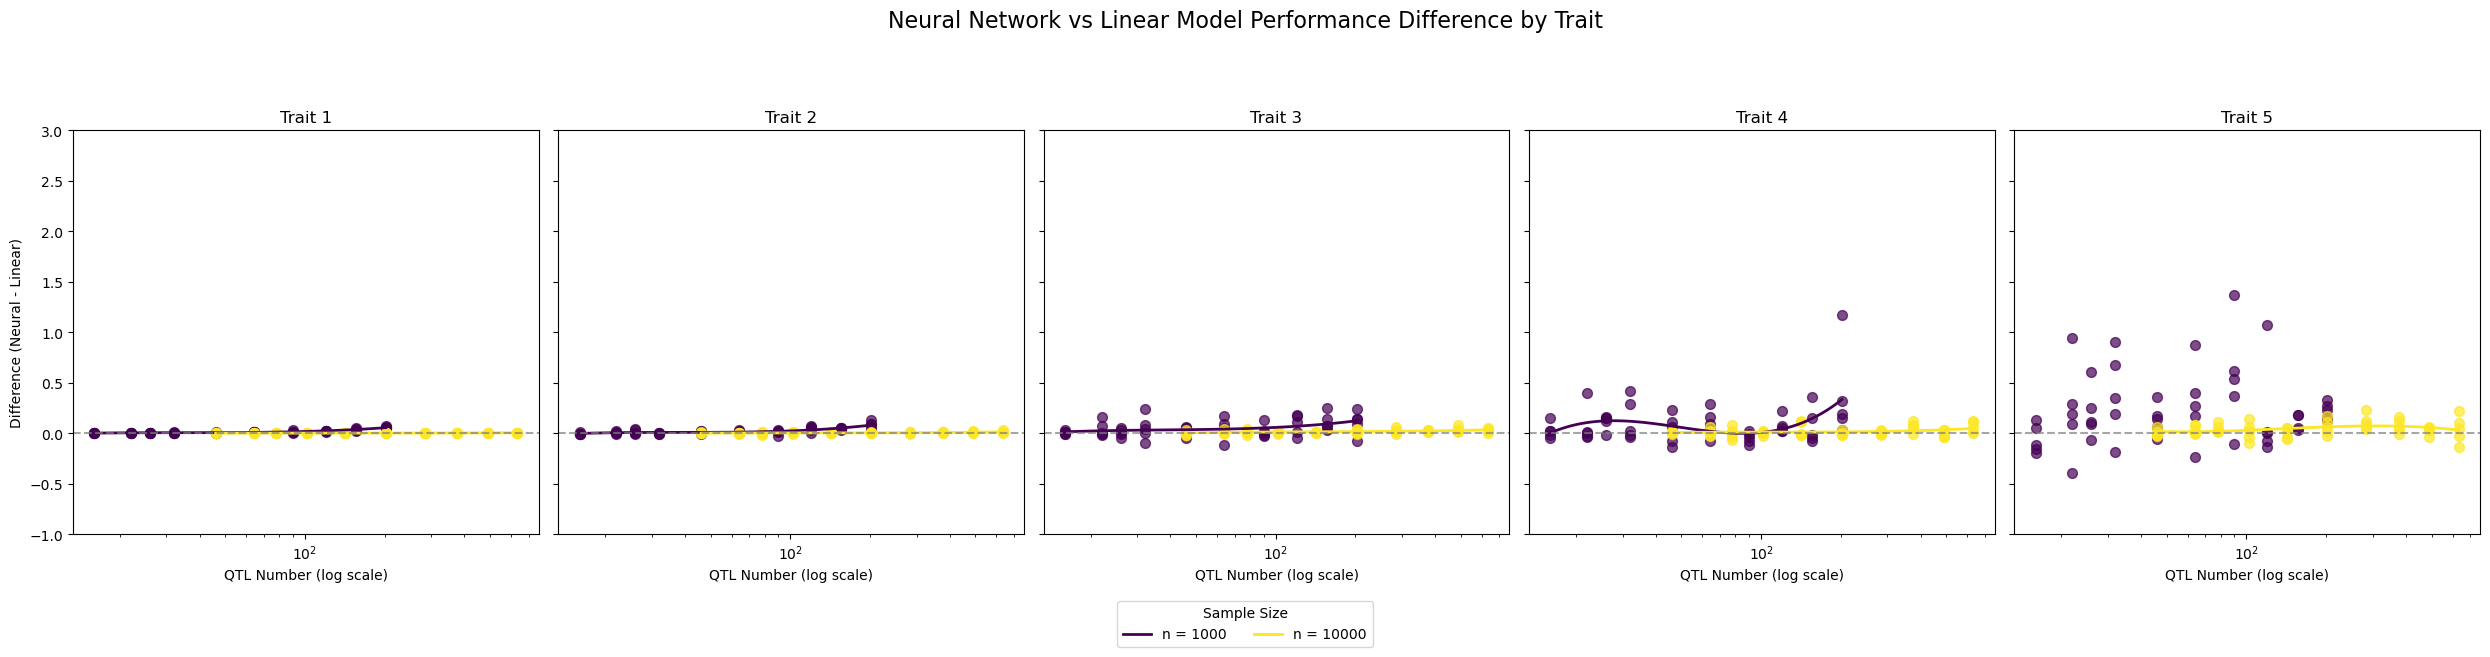

In [31]:
plot_difference_scatter(comparison_df)

Text(0, 0.5, 'gplinear Correlation')

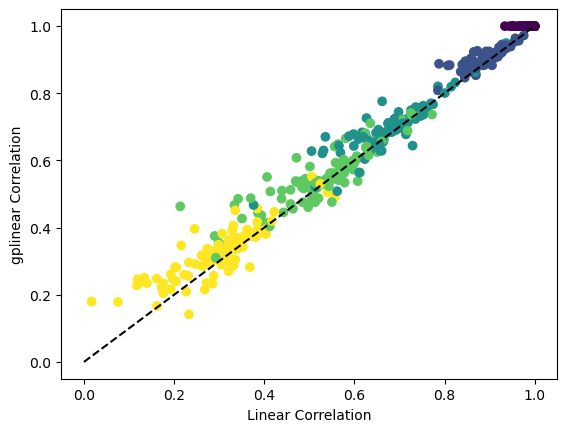

In [35]:
trait_data2 = comparison_df
plt.scatter(trait_data2['linear_correlation'], trait_data2['neural_correlation'], c=trait_data2['trait_number'])
plt.plot([0, 1], [0, 1], 'k--', label='1:1 line')
plt.xlabel('Linear Correlation')
plt.ylabel('gplinear Correlation')
